<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [893]:
%%capture
pip install pyswarms

In [894]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [895]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [896]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [897]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [898]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [899]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [900]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [901]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [902]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [903]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [904]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [905]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


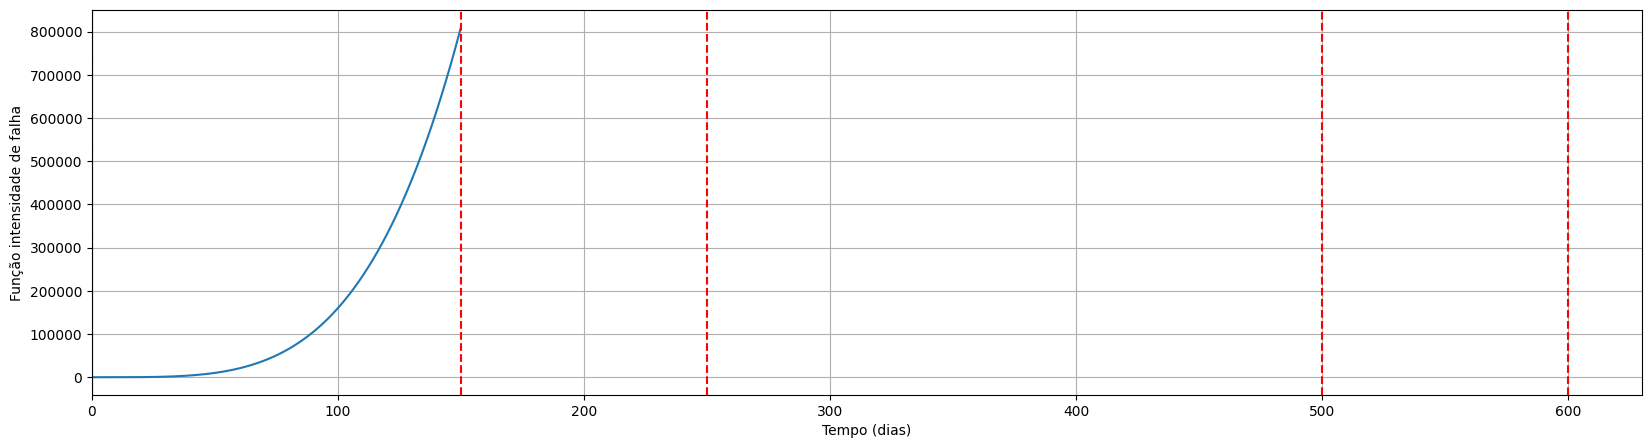

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [906]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [917]:
def objective_st(x):
    # Dicionario para severidades
    dict = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    global s
    T = [0]
    s_row = []
    cont = 0

    # Iterar sobre os elementos de x usando np.nditer()
    with np.nditer(x, op_flags=['readwrite']) as it:
        for number in it:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    ck = len(T) - 1
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])

    if ck == 0:
        return MAX_VALUE_CUSTO

    num_ciclos = ck

   # Obter os tempos para manutenções preventivas
    tempos_mp = T[1:]

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))
    Custo = np.sum(Ctotal)

    # Formatar o valor do custo
    Custo_formatado = format(Custo, '.2f')
    Custo_formatado = Custo_formatado.replace('.', '').replace(',', '.')

    print("")
    print("=========================================================================")
    print("")

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo_formatado)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir os tempos para manutenções preventivas
    print("Número de Sisemas:", m)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):
        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [921]:
num_particles = 3
max_iterations = 3
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-06 23:53:43,219 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/3

Número de ciclos de manutenção: 30 5
Tempos para manutenções preventivas: [0, 36, 142, 218, 254, 306, 369, 397, 437, 546, 585, 644, 660, 720, 911, 930, 1051, 1089, 1240, 1277, 1643, 1678, 1749, 1828, 1893, 1943, 1959, 2007, 2031, 2117, 2135]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]


Custo Total: 3910384614376412
Número de Ciclos de Manutenção: 30
Tempos para Manutenções Preventivas: [36, 142, 218, 254, 306, 369, 397, 437, 546, 585, 644, 660, 720, 911, 930, 1051, 1089, 1240, 1277, 1643, 1678, 1749, 1828, 1893, 1943, 1959, 2007, 2031, 2117, 2135]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção

pyswarms.single.global_best:  33%|███▎      |1/3, best_cost=3.91e+13

4 : 0.75
Severidade para Ciclo de Manutenção 7 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 8 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 9 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 10 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 11 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 12 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 13 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 14 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 15 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 16 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 17 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 18 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 19 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 20 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 21 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 22 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 23 do Sistema 4 : 0

pyswarms.single.global_best:  67%|██████▋   |2/3, best_cost=3.91e+13

Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 5 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 6 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 7 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 8 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 9 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 10 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 11 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 12 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 13 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 14 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 15 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 16 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 17 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 18 do Sistema 4 : 0.25
Severidade pa

pyswarms.single.global_best: 100%|██████████|3/3, best_cost=2.95e+13
2023-07-06 23:53:44,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 29474666493008.555, best pos: [3.57487996 1.39594217 3.6866774  1.96982753 5.00639876 6.32491581
 3.07852109 3.77540191 2.37660622 2.44995336 3.67116251 4.74045407
 6.5618613  1.88487634 4.14937108 5.18785005 3.64475272 5.23313549
 3.70094704 6.10281669 4.65951023 4.65810131 3.32106037 5.3511909 ]
2023-07-06 23:53:44,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


4 : 0.5
Severidade para Ciclo de Manutenção 9 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 10 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 11 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 12 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 13 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 14 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 15 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 16 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 17 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 18 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 19 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 20 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 21 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 22 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 23 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 24 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 25 do Sistema 4 : 0.

pyswarms.single.global_best:   0%|          |0/1

Número de ciclos de manutenção: 36 5
Tempos para manutenções preventivas: [0, 22, 43, 131, 184, 236, 324, 462, 505, 521, 565, 631, 672, 704, 789, 963, 995, 1068, 1125, 1184, 1419, 1466, 1494, 1577, 1618, 1655, 1736, 1750, 1777, 1844, 1948, 1961, 1991, 2063, 2093, 2116, 2144]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]


Custo Total: 3676926362304483
Número de Ciclos de Manutenção: 36
Tempos para Manutenções Preventivas: [22, 43, 131, 184, 236, 324, 462, 505, 521, 565, 631, 672, 704, 789, 963, 995, 1068, 1125, 1184, 1419, 1466, 1494, 1577, 1618, 1655, 1736, 1750, 1777, 1844, 1948, 1961, 1991, 2063, 2093, 2116, 2144]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 :

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.95e+13
2023-07-06 23:53:44,829 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 29474666493008.555, best pos: [3.75735065 1.45185798 4.16875828 2.28354704 5.37771732 6.36296766
 3.13790807 3.89237006 2.66185156 2.49055845 3.81538719 4.85382511
 0.00715391 2.03736076 4.31863372 5.43196783 3.85377434 5.37306441
 3.83364901 6.28251637 4.74478671 5.06033478 3.42292618 5.47560675]
2023-07-06 23:53:44,830 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.5
Severidade para Ciclo de Manutenção 16 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 17 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 18 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 19 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 20 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 21 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 22 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 23 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 24 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 25 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 26 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 27 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 28 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 29 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 30 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 31 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 32 do Sistema 5 : 0.5

pyswarms.single.global_best:   0%|          |0/1

Número de ciclos de manutenção: 37 5
Tempos para manutenções preventivas: [0, 26, 44, 140, 185, 238, 327, 469, 524, 568, 641, 675, 706, 738, 813, 846, 889, 909, 1069, 1162, 1185, 1220, 1362, 1395, 1420, 1515, 1536, 1564, 1639, 1708, 1764, 1784, 1838, 1887, 1932, 1978, 2008, 2040]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75]


Custo Total: 2487570129168450
Número de Ciclos de Manutenção: 37
Tempos para Manutenções Preventivas: [26, 44, 140, 185, 238, 327, 469, 524, 568, 641, 675, 706, 738, 813, 846, 889, 909, 1069, 1162, 1185, 1220, 1362, 1395, 1420, 1515, 1536, 1564, 1639, 1708, 1764, 1784, 1838, 1887, 1932, 1978, 2008, 2040]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.49e+13

 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 31 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 32 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 33 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 34 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 35 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 36 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 37 do Sistema 5 : 0.75



2023-07-06 23:53:45,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24875701291684.5, best pos: [3.89976711 1.48595241 4.60129395 2.52828792 5.69370863 6.38761349
 3.18449321 3.96315237 2.87960971 2.52073765 3.92850638 4.93261258
 0.64514898 2.15644941 4.45172941 5.63401974 4.01498006 5.47538767
 3.93436751 6.42768207 4.80748762 5.37297414 3.50252648 5.55597519]
2023-07-06 23:53:45,277 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1

Número de ciclos de manutenção: 32 5
Tempos para manutenções preventivas: [0, 45, 149, 186, 242, 330, 366, 474, 527, 649, 677, 708, 835, 921, 949, 970, 1011, 1068, 1129, 1145, 1187, 1313, 1361, 1422, 1671, 1790, 1840, 1867, 1904, 1922, 2012, 2082, 2123]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5]


Custo Total: 4573768034819722
Número de Ciclos de Manutenção: 32
Tempos para Manutenções Preventivas: [45, 149, 186, 242, 330, 366, 474, 527, 649, 677, 708, 835, 921, 949, 970, 1011, 1068, 1129, 1145, 1187, 1313, 1361, 1422, 1671, 1790, 1840, 1867, 1904, 1922, 2012, 2082, 2123]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.49e+13
2023-07-06 23:53:45,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24875701291684.5, best pos: [4.02794193 1.5166374  4.99057604 2.74855472 5.97810081 6.40979473
 3.22641984 4.02685644 3.07559204 2.54789892 4.03031366 5.00352131
 1.21934454 2.26362919 4.57151553 5.81586647 4.1600652  5.5674786
 4.02501417 6.55833119 4.86391844 5.65434957 3.57416675 5.62830679]


do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 18 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 19 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 20 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 21 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 22 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 23 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 24 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 25 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 26 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 27 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 28 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 29 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 30 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 31 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 32 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 2 do Si

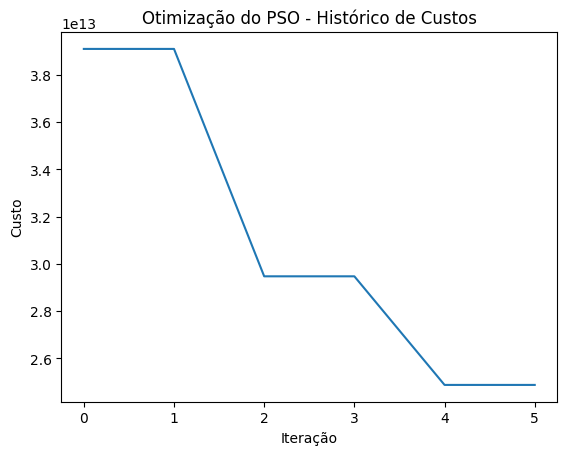

In [922]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

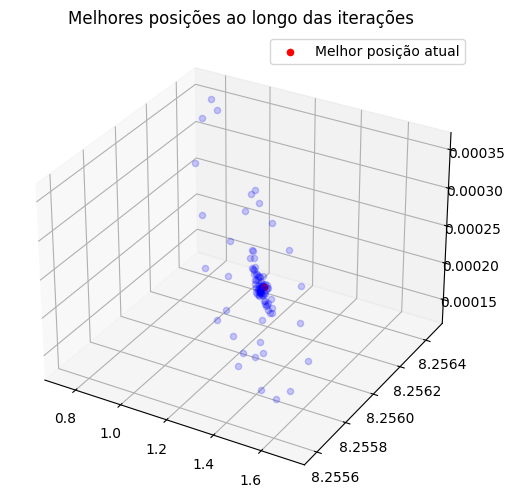

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor custo: 8.581271659643846e+16
Melhor custo pessoal (pbest) de cada partícula: 9.400757517909582e+16


In [910]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")

print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])